In [1]:
import numpy as np
import gdspy
import os
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import shapely
import tqdm
import matplotlib.image
from geneticalgorithm import geneticalgorithm as ga
from slice_utilities import poly_intersection, slice_gds, cost_reward

In [2]:
from EDA_class import EDA
eda_class = EDA('130nm_edit_0001.gds','top_io')

/home/lior/.local/lib/python3.10/site-packages/gdspy/library.py:2291: UserWarning: [GDSPY] GDSII elements of type BOX are imported as polygons.
  self.read_gds(infile, **kwargs)


In [3]:
bounding_box = [(1200, 730),(1200, 775),(1390, 775),(1390,762), (1210, 762), (1210, 730)]
eda_class.Set_BP(bounding_box)
eda_class.Slice_GDS()

Layer: 108, Datatype: 0, Polygons: 59
Layer: 66, Datatype: 0, Polygons: 27
Layer: 61, Datatype: 0, Polygons: 169
Layer: 62, Datatype: 0, Polygons: 178
Layer: 63, Datatype: 0, Polygons: 155
Layer: 64, Datatype: 0, Polygons: 139
Layer: 65, Datatype: 0, Polygons: 67
Layer: 127, Datatype: 0, Polygons: 59
Layer: 30, Datatype: 0, Polygons: 57
Layer: 50, Datatype: 0, Polygons: 202
Layer: 43, Datatype: 0, Polygons: 83
Layer: 40, Datatype: 0, Polygons: 71
Layer: 10, Datatype: 0, Polygons: 150
Layer: 14, Datatype: 0, Polygons: 59
Layer: 74, Datatype: 0, Polygons: 66
Layer: 73, Datatype: 0, Polygons: 109
Layer: 72, Datatype: 0, Polygons: 304
Layer: 71, Datatype: 0, Polygons: 115
Layer: 70, Datatype: 0, Polygons: 106


In [4]:
eda_class.Set_Metal_Layers([61,62,63,64,65,66])
eda_class.Set_Via_Layers([70,71,72,73,74])

In [5]:
eda_class.Slice_Signals(True)

In [6]:
eda_class.Set_Signals_Num([0,5])

In [7]:
eda_class.Build_Reward_masks()
eda_class.Build_Cost_mask()

{'signal number is 0'}
{'signal number is 5'}


# Setting the GA

In [8]:
# Setting the ga parameters
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':10000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

In [9]:
def cost_reward(x,y,l,s):
    ind_l=(metal_layers).index(l)
    cost= 0
    for i in range(ind_l,len(metal_layers)):
            cost += sum(sum(cost_mask[i][(x-20):(x+20),(y-20):(y+20)]))
    reward = 0
    if s==1:
        reward = sum(sum(reward_mask1[ind_l][(x-20):(x+20),(y-20):(y+20)]))
    elif s==2:
        reward = sum(sum(reward_mask2[ind_l][(x-20):(x+20),(y-20):(y+20)]))
    
    return cost,reward

In [10]:
reward_mask1 = eda_class.reward_mask1
reward_mask2 = eda_class.reward_mask2
cost_mask = eda_class.cost_mask
W,H = cost_mask[0].shape
metal_layers = eda_class.Metal_Layers


In [11]:
def cost_func(X):
    x1=int(X[0])
    y1=int(X[1])
    l1=int(X[2])
    x2=int(X[3])
    y2=int(X[4])
    l2=int(X[5])
    cost1, reward1 = cost_reward(x1,y1,l1,1)
    cost2, reward2 = cost_reward(x2,y2,l2,2)
    cost = cost1+cost2
    reward = 100*(reward1+reward2)
    L_cost = (x1-x2)**2+(y1-y2)**2
    alpha=0.001
    if (cost>0 or reward1==0 or reward2==0):
        return cost
    else:
        return -reward + alpha*L_cost

 The best solution found:                                                                           
 [5751.08502042 3633.72350337   66.         5751.02673067 3633.32800699
   65.        ]

 Objective function:
 -210666.6666666666


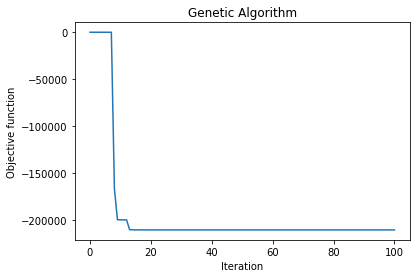

In [12]:
varbound=np.array([[20,W-20],[20,H-20],[61,66],[20,W-20],[20,H-20],[61,66]])
vartype=np.array([['real'],['real'],['int'],['real'],['real'],['int']])
model=ga(function=cost_func,dimension=6,variable_type_mixed=vartype,variable_boundaries=varbound,algorithm_parameters=algorithm_param)
model.run()

In [13]:
eda_class.plot_results(model.best_variable,20)